<a href="https://colab.research.google.com/github/k-ganda/air_quality_forcasting_ML/blob/main/notebook/air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the datasets

train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


From the above output, we get to know the structure of our data.

There are 12 columns, the last column pm2.5 is the target column. Visible null values in the pm2.5 column.

The No column gives the indexing of each row and won't be significant in building our model.

Next, Let's get the list of the columns present and check their datatypes to know if we will be encoding some of them to numeric values.

In [5]:
# Checks for the datatypes in our dataset
train.dtypes

,0
No,int64
DEWP,float64
TEMP,float64
PRES,float64
Iws,float64
Is,float64
Ir,float64
datetime,object
cbwd_NW,float64
cbwd_SE,float64


We don't seem to have any categorical variables, all our columns are either integers or or floats.

Except the datetime which is is an object and it's cause it contains dates.

Next, we will get summary statistics:

In [6]:
# Gives detailed summary statistics
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


From the summary statistics, we can see valauble insights:

For example:
There are 30676 rows in our train dataset.

The dew point values range from -2.14 to 1.81.

Temperatures seem to be around freezing from their mean being on the negative side.

There's a wide spread in pm2.5 values seen from the range of 0 to 994.

# Visualizations

We can further learn about our dataset; the relastionship between the variables by plotting histograms, correlation heatmaps.

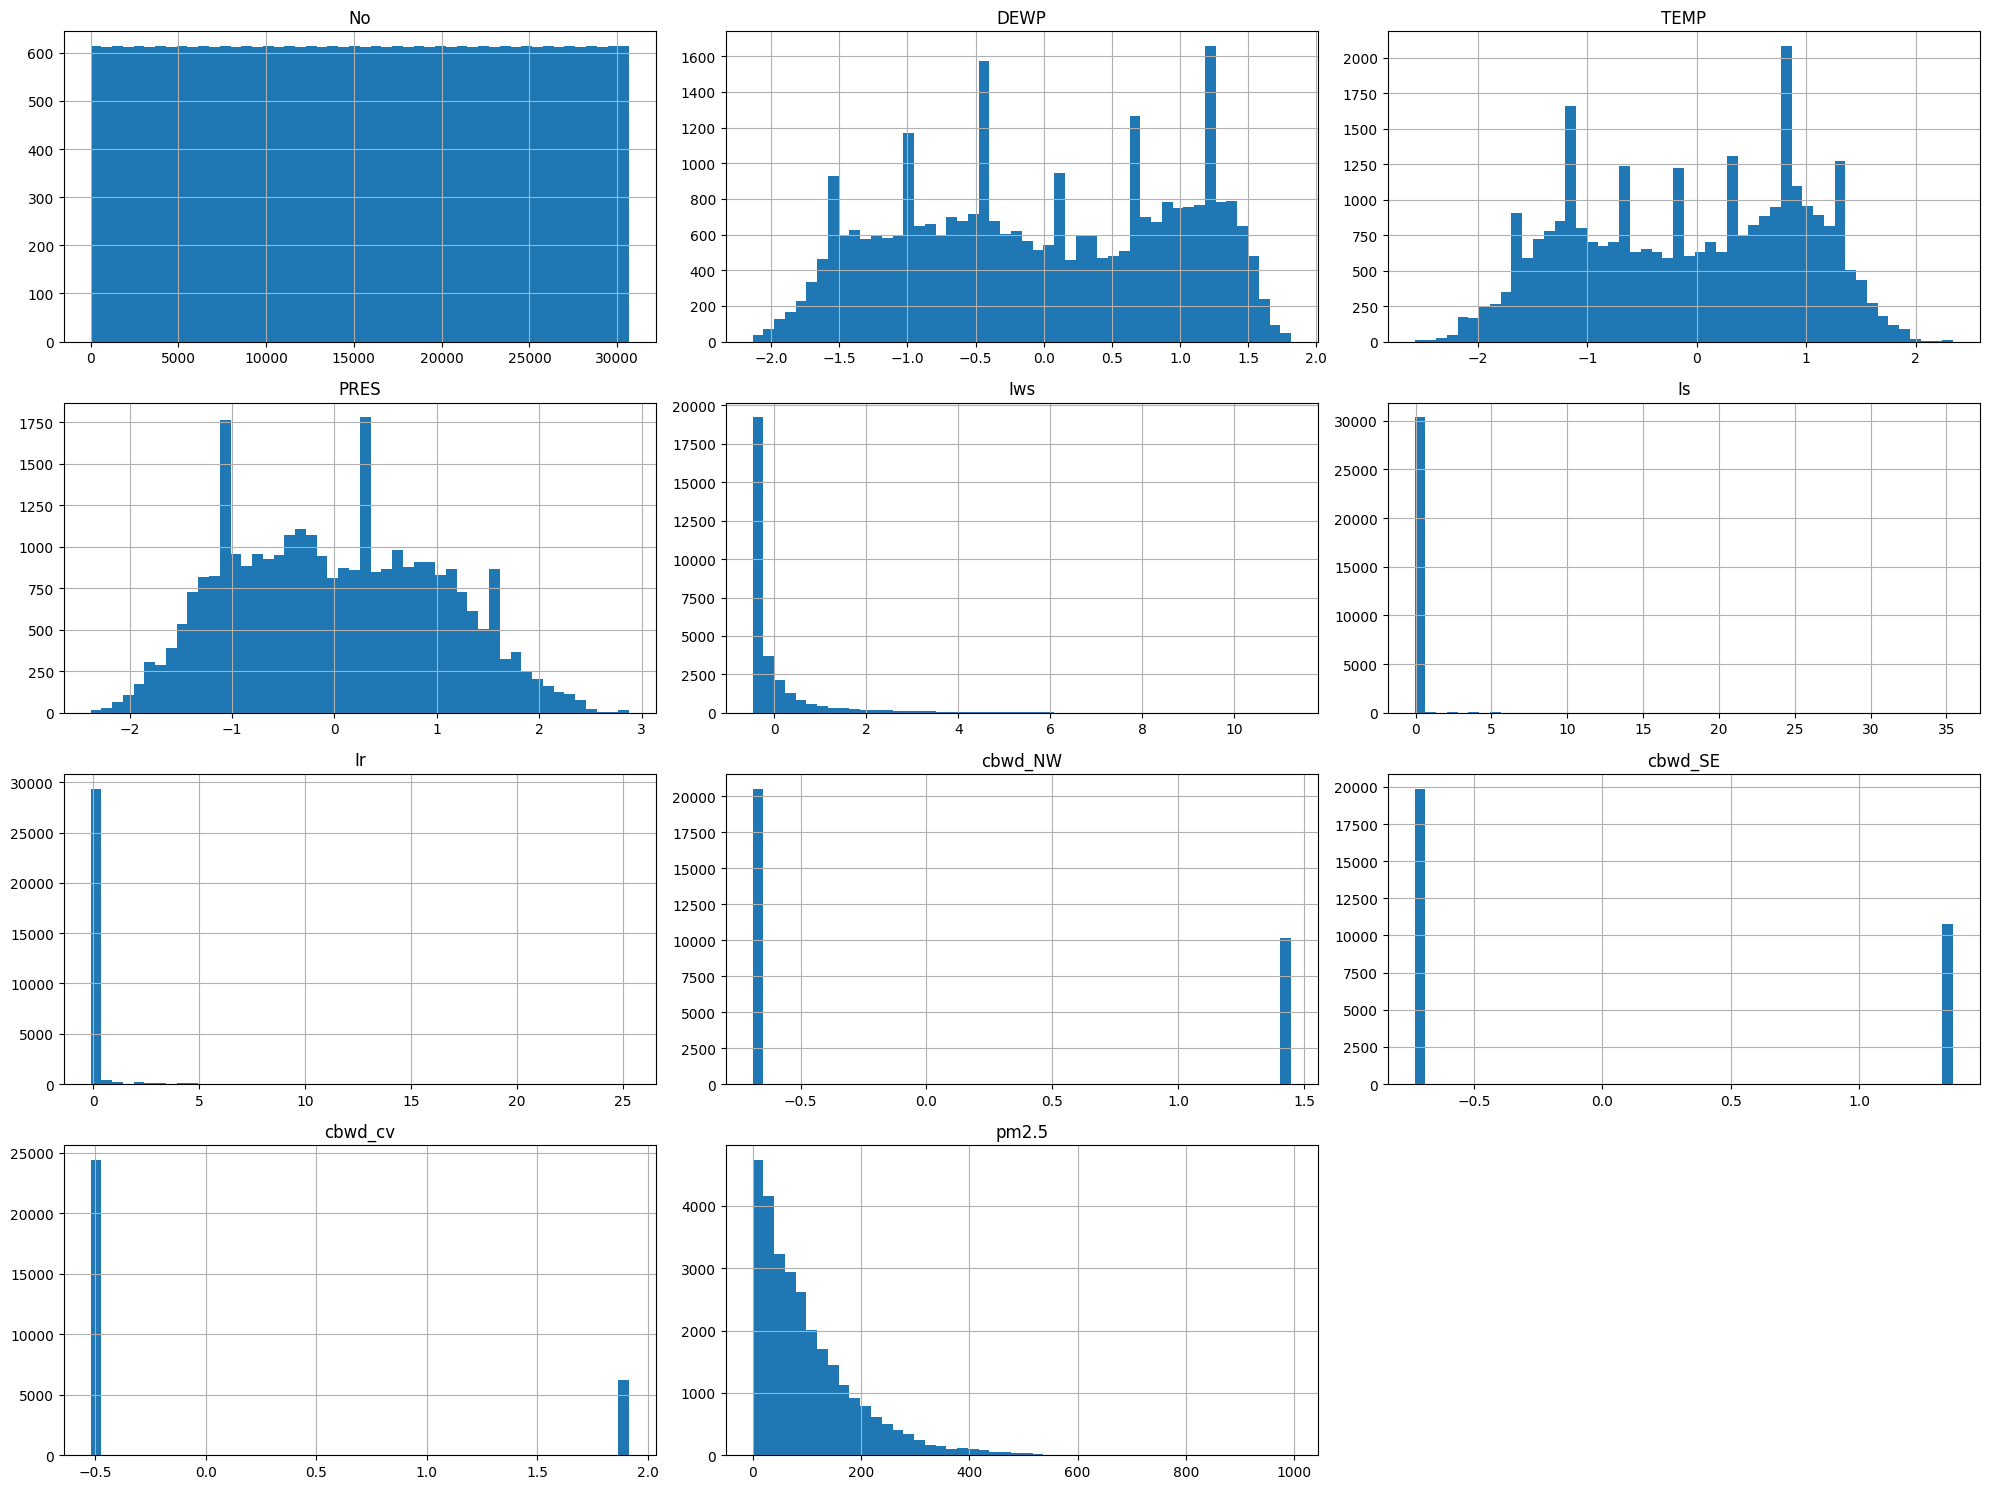

In [7]:
# Let's plot histograms
train.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

What story are the histograms passing across?

pm2.5: The distribution is skewed to the right with a long tail towards higher pollution levels. Indicating instances of high pm2.5 concentrations.

Temperature and Pressure: Well distributed values(normal distribution)

DewPoint(DEWP): Well distributed values with a few peaks.

lws(windspeed): This is also skewed to the right. Most instances are low wind speeds but there are also strong winds.

ls(cumulative snowfall), lr(cumulative rainfall) have most of their values at zero and sparse.

Let's convert the Datetime column into a format accepted for time series.

This is done by setting the datetime column as index.

In [8]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


Plotting correlation heatmap;

This helps isualize the relationships between variables in the dataset and know which variables are significant in predicting pm2.5.


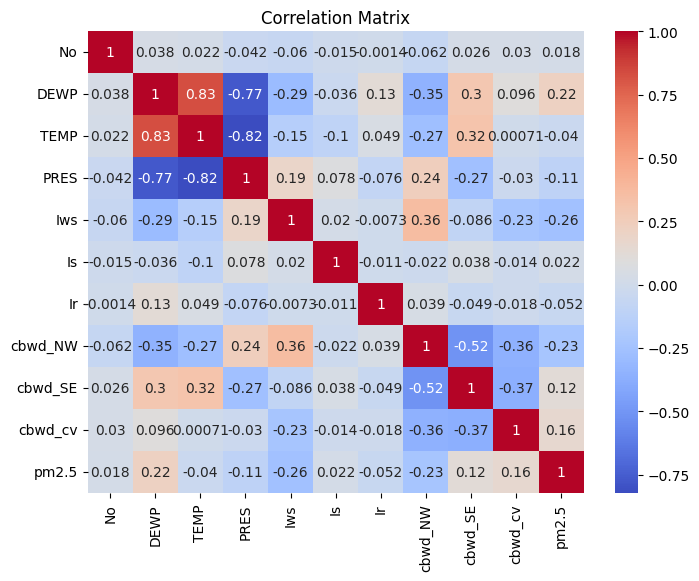

In [9]:
import seaborn as sns

# Calculates the correlation matrix
correlation_matrix = train.corr()

# Creates a figure wuth specific size
plt.figure(figsize=(8, 6))

# Using seaborn, the heatmap is created with coolwarm color
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Sets the title of the heatmap
plt.title("Correlation Matrix")

# Displays the heatmap
plt.show()

From the heatmap, here are some takeaways

1. Strong positive correlation between DEWP and Temp(0.83).

2. Strong negative correlation between PRES and both Dewp(-0.77) and Temp(-0.82). Means that as pressure increases, dewp point decreases. SImilarly applies to temp. As temperature increases, pressure decreases.

3. The wind direction variables (cbwd_NW, cbwd_SE, cbwd_cv) show some correlations with PM2.5, suggesting that wind direction might play a role in influencing air pollution levels. For example, cbwd_NW (northwest wind) has a negative correlation (-0.23) with PM2.5, indicating that winds from the northwest direction might be associated with lower PM2.5 levels.

4. Strong positive correlation between DEWP and PM2.5. (0.22), dewpoint therefore also plays a role in air pollution levels.

Almost all variables play a key role in predicting the target variable pm2.5. Not advisable to drop them.

# Handle missing values


- Check the dataset for missing values and decide how to handle them.

- Fill the missing values by interpolation(estimating unknown values between known values/surrounding values)

Handling missing values is relevant to our model as missing values can introduce bias into the model and therefore lead to inaccurate forecasts.

In [10]:
# Check for missing values
print("Missing Values in Training Data:")
print(train.isnull().sum())

Missing Values in Training Data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


There are 1921 missing values in the pm2.5 column.

We will handle them by interpolation.

 **Note:**  Other methods were experimented such as filling with backward and forward fill, filling with mean and deletion. Interpolation gave better results.

In [11]:
# Interpolation of pm2.5
train['pm2.5'] = train['pm2.5'].interpolate(method='linear')


In [12]:
# Confirm if all null are handled
print("Missing Values in Training Data:")
print(train.isnull().sum())

Missing Values in Training Data:
No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
pm2.5      24
dtype: int64


After interpolation, it appears that there are still 24 missing values.

Since interpolation fills nulls based on adjacent time points, the null values will either be at the start or the end.

Confirm where the null values are located before deciding on next step.

In [13]:
# Checks the missing values in the pm2,5
missing_pm25_rows = train[train['pm2.5'].isna()]
print(missing_pm25_rows)

                     No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                    
2010-01-01 00:00:00   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353   
2010-01-01 01:00:00   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353   
2010-01-01 02:00:00   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353   
2010-01-01 03:00:00   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353   
2010-01-01 04:00:00   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353   
2010-01-01 05:00:00   6 -1.442309 -1.840273  0.053790 -0.155751 -0.069353   
2010-01-01 06:00:00   7 -1.442309 -1.758296  0.053790 -0.093164 -0.069353   
2010-01-01 07:00:00   8 -1.442309 -1.758296  0.053790 -0.057371 -0.069353   
2010-01-01 08:00:00   9 -1.442309 -1.758296  0.053790  0.005216 -0.069353   
2010-01-01 09:00:00  10 -1.511594 -1.676318  0.053790  0.067804 -0.069353   
2010-01-01 10:00:00  11 -1.442309 -1.594341  0.053790  0.148187 -0.069353   

It appears that they are located at the start of the time series, spanning the first 24 hours of January 1, 2010.

We can either drop them or fill them with zeros. Dropping will reduce our train size and can result in loss of valuable data. To prevent this, we will fill the remaining null values with zeros(0).

In [14]:
# Fill NaN values with 0
train['pm2.5'] = train['pm2.5'].fillna(0)

In [15]:
# Confirm if all null are handled
print("Missing Values in Training Data:")
print(train.isnull().sum())

Missing Values in Training Data:
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
dtype: int64


# Stationarity

The next step is to check for stationarity in our time series.

**Relevance of this step to the model:**

Stationary time series has statistical properties — such as its mean, variance, and autocorrelation — that remain consistent over time.

**Non-stationary data** can lead to *misleading* results in time series forecasting, as patterns such as trends or seasonality may change over time, affecting the model’s accuracy. To address this, it's essential to *transform the data* to make it stationary. Techniques like **detrending** and **decomposition** can help remove these time-dependent structures, ensuring that the data's statistical properties remain *constant over time* and improving the model's performance.


There are several methods to check for stationarity; check visually by plotting time series and checking for trends, or Augmented Dickey Fuller test.


Augmented Dickey Fuller test will be implemented


In [16]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test_result = adfuller(train['pm2.5'])

# Print results
print(f"ADF Statistic: {adf_test_result[0]}") # The test statistice
print(f"p-value: {adf_test_result[1]}") # the p-value

print("Critical Values:")
# Print the critical values for different confidence levels
for key, value in adf_test_result[4].items():
    print(f"\t{key}: {value}")

# Interpret the results based on the p-value
# If the p-value is less than or equal to 0.05, we reject the null hypothesis
# and conclude that the time series is stationary
if adf_test_result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -17.368264122886565
p-value: 5.155758965549318e-30
Critical Values:
	1%: -3.430563532117516
	5%: -2.8616343754950444
	10%: -2.5668202331836762
The time series is stationary.


Our time series is stationary, we will move to the next step.

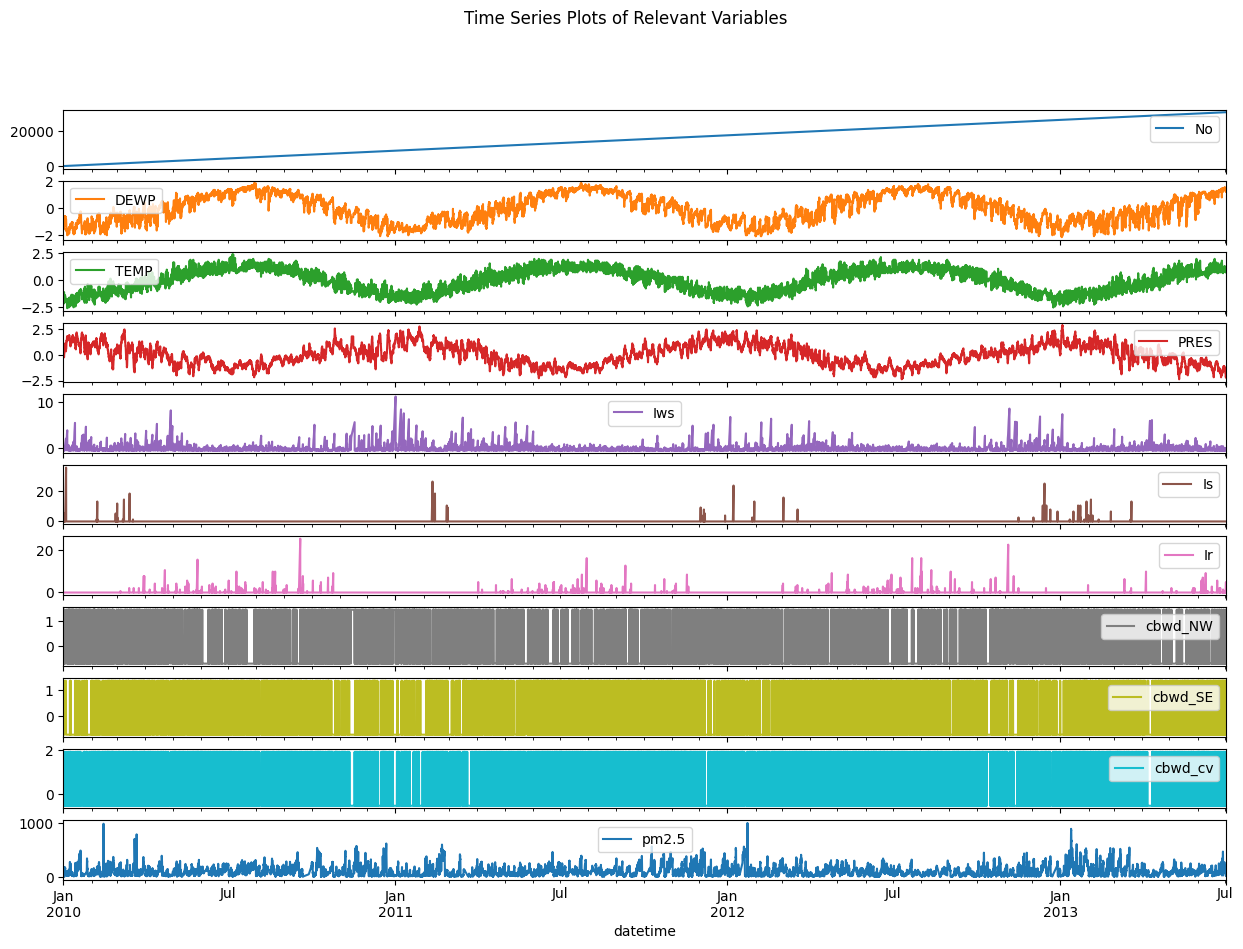

In [17]:
# Plotting variables to analyze trend over time
train.plot(subplots=True, figsize=(15, 10), title="Time Series Plots of Relevant Variables")
plt.show()

Temperature displays a cyclical pattern with peaks in summer and troughs in winter.

 Dewpoint has a similar pattern as temperature, this affirms the observation in the correlation heatmap that showed strong positive correlation between temperature and Dewpoint.

Pressure shows a cyclical pattern but inversely to temperature and dewpoint, also observed from negative correlation from the heatmap.

Windspeed(lws): Scattered high peaks, especially in the month of Jan of each year.

Snowfall(ls): Concentrated in winter months, where there is a trough in temperature.

Pm2.5: There are fluctuations throughout the four years with peaks in colder months


# Separate features and target

- The No column will be dropped. The rest of the columns become the features while the pm2.5 column is the target.

After separating, the next step will be

# Scaling.

**Scaling:** brings all features to a *similar range* preventing any **dominance** and thus allowing the model to give *equal weight* to all features during training leading to improved convergence and overall better performance to our model.

Standardscaler, MinMaxscaler and Robustscaler were experimented. Standard scaler performed better and hence chosen.

# Time windowing

Refers to the period of time that you want to forecast based on the data.

Time windows will serve as input for our model, allowing it learn patterns across the sequences and generalize well.


# Reshaping

Once we transform our time series data to windows, we will need to reshape(change the format) before feeding it to the LSTM model. This is becasue LSTM require 3D format(samples, timesteps, features) to effectively process the sequential data, learn temporal relationships within each window, and ultimately improve forecasting accuracy.


In [18]:
# X_train- features for training. Dropping target and No
X_train = train.drop(['pm2.5', 'No'], axis=1)
# y_train- Target variable
y_train = train['pm2.5']

In [20]:
# Scaling the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
# Fit scaler to train and transform it
X_train_scaled = scaler.fit_transform(X_train)

In [21]:
# Time windowing

def create_windows(data, window_size, step_size):
    """
    Creates windows from input data.
    Args:
        data: Input data(X_train_scaled)
        window_size: No of past data points to consider
        step_size: Step size for sliding the window
    """
    windows = []
    # Iterates through the data, creating windows
    for i in range(0, len(data) - window_size + 1, step_size):
        # Extract a window od data
        window = data[i:i + window_size]
        # Add window to list of windows
        windows.append(window)
    # Converts list of windows to Np array
    return np.array(windows)

# Each window contain 24 hrs
window_size = 24
step_size = 1 # Moving the window by 1 hr at a time

# Creates the windows
X_train_windows = create_windows(X_train_scaled, window_size, step_size)

In [22]:
# Creating Input-output sequences

# Creates target sequences starting from index to end of target data
# Then converts to a numpy array
y_train_windows = y_train[window_size - 1:].values

print(X_train_windows.shape) # Prints shape of input windows(X)
print(y_train_windows.shape) # Prints shape of target Y

(30653, 24, 9)
(30653,)


In [23]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_lstm = X_train_windows.reshape((X_train_windows.shape[0],
                                        X_train_windows.shape[1],
                                        X_train_scaled.shape[1]))

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop, SGD

# define model
model = Sequential([
    LSTM(32, activation='tanh', input_shape=(window_size, X_train.shape[1]),
         return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    LSTM(16, activation='tanh', kernel_regularizer=l2(0.01)),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 24, 32)              │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,529 (33.32 KB)

 Trainable params: 8,529 (33.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_windows,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - lambda: 122.8145 - loss: 15571.6777 - val_lambda: 110.5814 - val_loss: 20042.4941
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - lambda: 114.6085 - loss: 13673.1963 - val_lambda: 102.8763 - val_loss: 17962.6875
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - lambda: 105.7556 - loss: 11738.9707 - val_lambda: 96.9607 - val_loss: 16280.2109
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - lambda: 99.1465 - loss: 10307.2012 - val_lambda: 92.5182 - val_loss: 14928.4697
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - lambda: 94.6415 - loss: 9180.5459 - val_lambda: 87.4560 - val_loss: 13565.0703
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - lambda: 94.6926 - loss: 8218.4639 - val_lambda: 84.4439 - val_loss: 12319.0332
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - lambda: 94.7599 - loss: 7596.4570 - val_lambda: 82.5343 - val_loss: 11334.2441
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 24

958/958 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


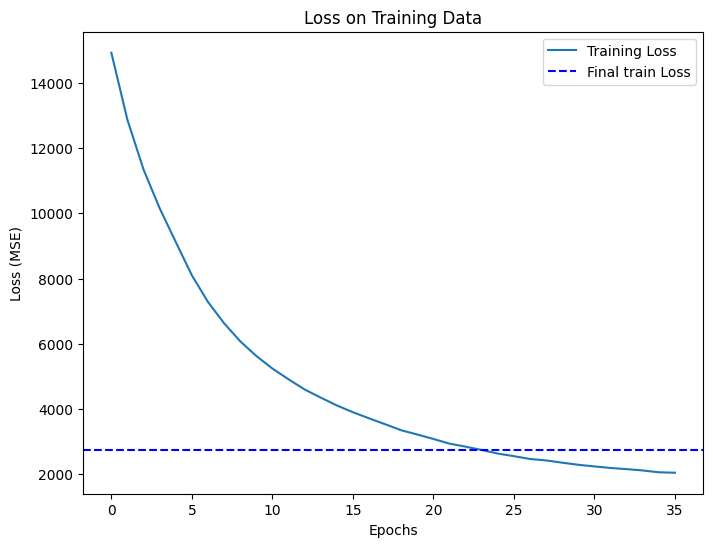

Final Training Loss (MSE): 2731.1980037740805


In [ ]:
# Calculate training loss
train_predictions = model.predict(X_train_lstm)
train_loss = np.mean((y_train_windows - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [ ]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test_scaled = scaler.transform(X_test)

# Pad the test data to get predictions for all rows
padding_size = window_size - 1  # Number of data points to pad
padded_X_test_scaled = np.pad(X_test_scaled, ((padding_size, 0), (0, 0)), mode='reflect')

X_test_windows = create_windows(padded_X_test_scaled, window_size, step_size)
X_test_lstm = X_test_windows.reshape((X_test_windows.shape[0], X_test_windows.shape[1], X_test_scaled.shape[1]))

# Make predictions
predictions = model.predict(X_test_lstm)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Remove the predictions corresponding to the padded data to match the original test set size
predictions = predictions[-len(test):]

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID'
submission = submission.sort_values(by='row ID')

# Save the submission file
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
